<a href="https://colab.research.google.com/github/aanilkumarreddy/DataDiggers/blob/main/dataOptimizationGOOG_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd #Data manipulation and analysis
import numpy as np #Numerical computing
import matplotlib.pyplot as plt #Data Visualzation
import seaborn as sns #Data Visualzation
import time #Various time-related functions

In [ ]:
!pip install --upgrade pandas-datareader
!pip install --upgrade pandas

     |████████████████████████████████| 109 kB 5.6 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [49]:
#Settings for appropriate display  

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [50]:
#Ignoring all warning ⚠ messages thrown

import warnings
warnings.filterwarnings('ignore')

In [51]:
import pandas_datareader as pdr #Remote data access for pandas
from datetime import date

df = pdr.DataReader('GOOG', data_source='yahoo', start='2018-01-01', end = "2021-12-31")
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,1066.939941,1045.229980,1048.339966,1065.000000,1237600,1065.000000
2018-01-03,1086.290039,1063.209961,1064.310059,1082.479980,1430200,1082.479980
2018-01-04,1093.569946,1084.001953,1088.000000,1086.400024,1004600,1086.400024
2018-01-05,1104.250000,1092.000000,1094.000000,1102.229980,1279100,1102.229980
2018-01-08,1111.270020,1101.619995,1102.229980,1106.939941,1047600,1106.939941


In [52]:
df = df["Close"]
df = pd.DataFrame(df)
df.head()

,Close
Date,
2018-01-02,1065.000000
2018-01-03,1082.479980
2018-01-04,1086.400024
2018-01-05,1102.229980
2018-01-08,1106.939941


In [53]:
df.shape

(1008, 1)

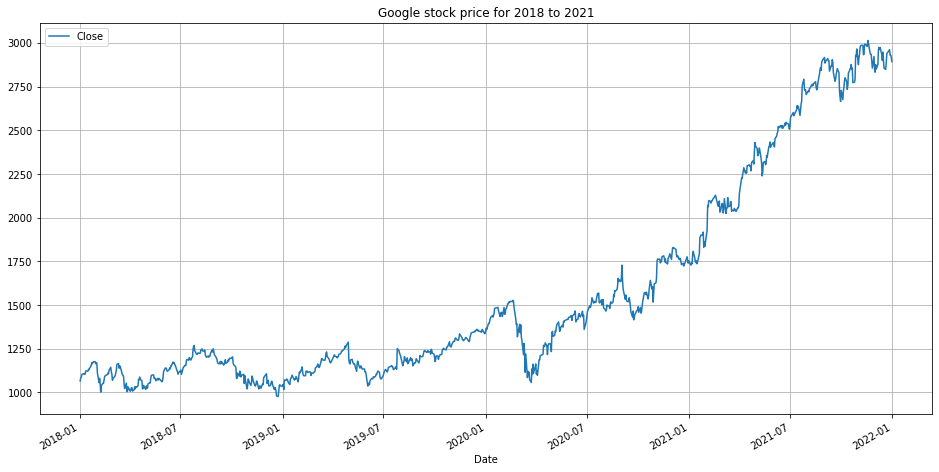

In [54]:
df.plot(figsize=(16,8), title = "Google stock price for 2018 to 2021", grid = True)

In [55]:
#Convert the dataframe to a numpy array

dataset = df.values

In [56]:
#Scale the data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [76]:
#Create the train and test data set

train_data = scaled_data[2:702]
test_data = scaled_data[642:]

In [77]:
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(58, len(train_data)):
    x_train.append(train_data[i-58:i, 0])
    y_train.append(train_data[i, 0])
        
#Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [78]:
#Create the data sets x_test and y_test

training_data_len = train_data.shape[0]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(58, len(test_data)):
    x_test.append(test_data[i-58:i, 0])
    
#Convert the data to a numpy array
x_test = np.array(x_test)

#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [80]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Building the LSTM model
model = Sequential()
model.add(LSTM(int(input("LSTM 1: ")), return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(int(input("LSTM 2: ")), return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

#Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Training the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

LSTM 1: 5
LSTM 2: 5
642/642 [==============================] - 17s 21ms/step - loss: 0.0010


In [81]:
#Get the predicted values 

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [82]:
#Evaluating Model Performance

import math
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean Square Error (MSE): '+str(mean_squared_error(predictions, y_test)))
print('Mean Absolute Error(MAE): '+str(mean_absolute_error(predictions, y_test)))
print('Root Mean Square Error (RMSE): '+str(math.sqrt(mean_squared_error(predictions, y_test))))

Mean Square Error (MSE): 60632.956919985016
Mean Absolute Error(MAE): 194.32976383357854
Root Mean Square Error (RMSE): 246.23760257114472


In [83]:
trn = df[:training_data_len]
tst = df[training_data_len:]
tst['Predictions'] = predictions

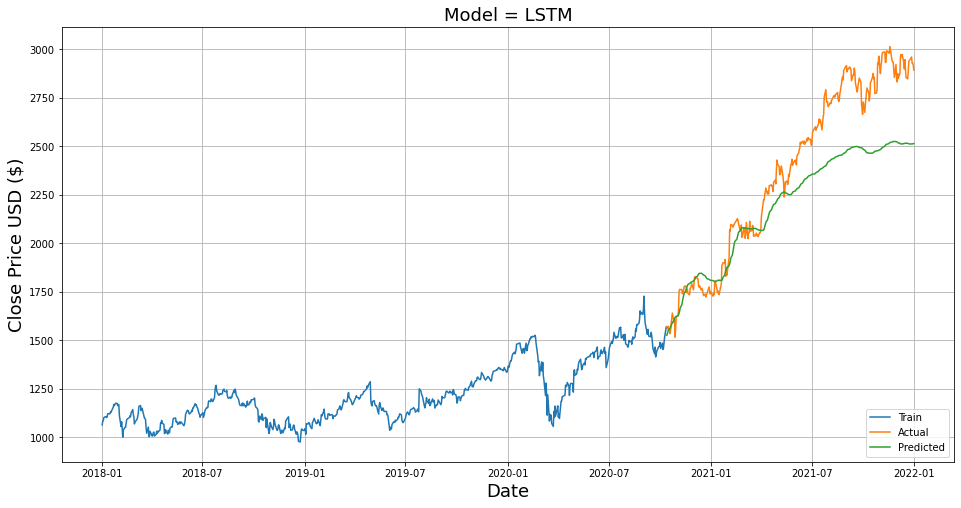

In [84]:
#Visualize the entire data

plt.figure(figsize=(16,8))
plt.title('Model = LSTM', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(trn['Close'])
plt.plot(tst[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.grid()
plt.show()

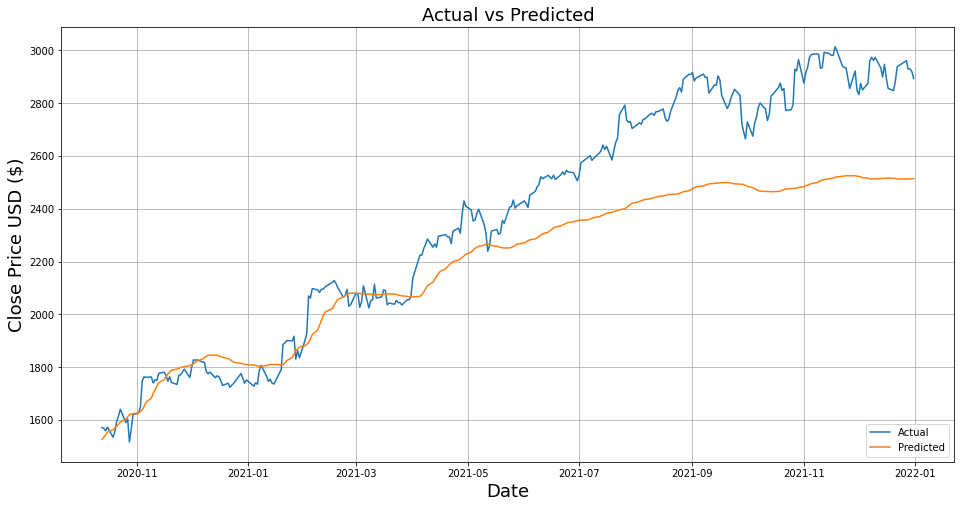

In [85]:
#Visualize the test data

plt.figure(figsize=(16,8))
plt.title('Actual vs Predicted', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(tst[['Close', 'Predictions']])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.grid()
plt.show()

In [86]:
res = tst['Close'] - tst['Predictions']
res = pd.DataFrame(res)
res.rename(columns= {0: 'Residual'}, inplace = True)

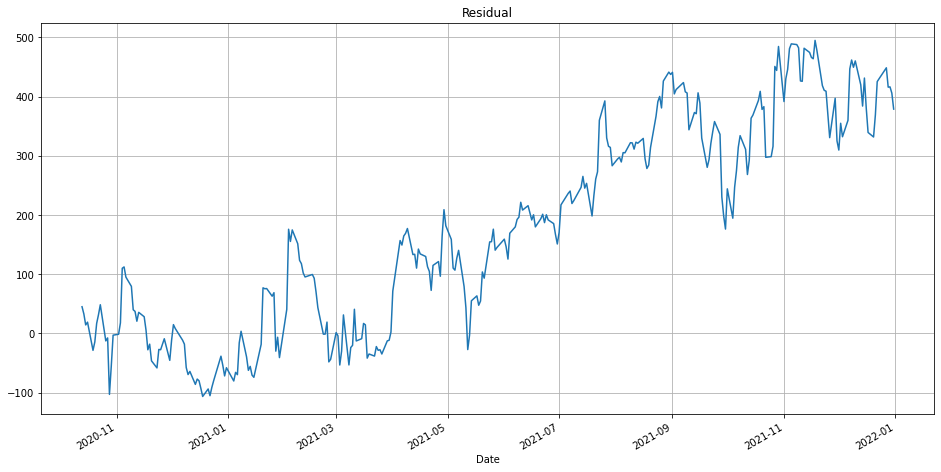

In [87]:
#Residual plot

res["Residual"].plot(title = 'Residual', figsize = (16,8), grid = True)

In [88]:
#Simple Moving Average of Residual

res['SMA_1'] = res.Residual.rolling(7, min_periods=1).mean() #Period of 1 week
res['SMA_2'] = res.Residual.rolling(14, min_periods=1).mean() #Period of 2 weeks
res['SMA_4'] = res.Residual.rolling(28, min_periods=1).mean() #Period of 4 weeks

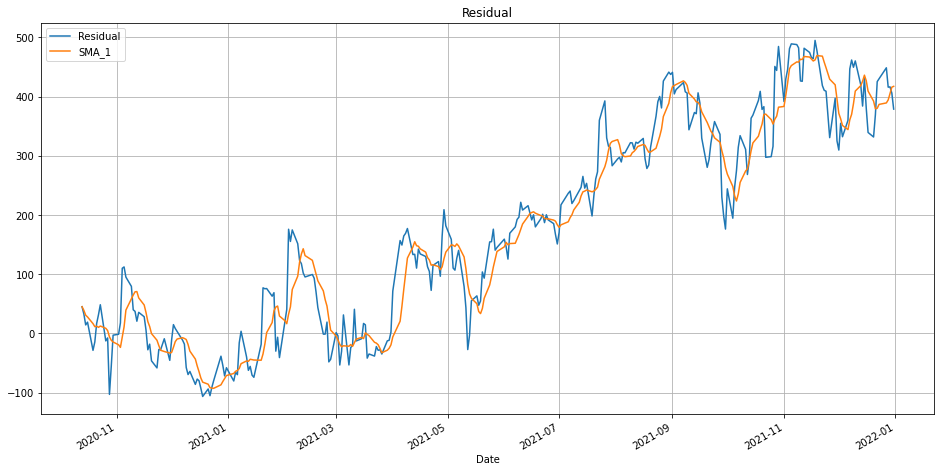

In [89]:
res[["Residual", "SMA_1"]].plot(title = 'Residual', figsize = (16,8), grid = True)

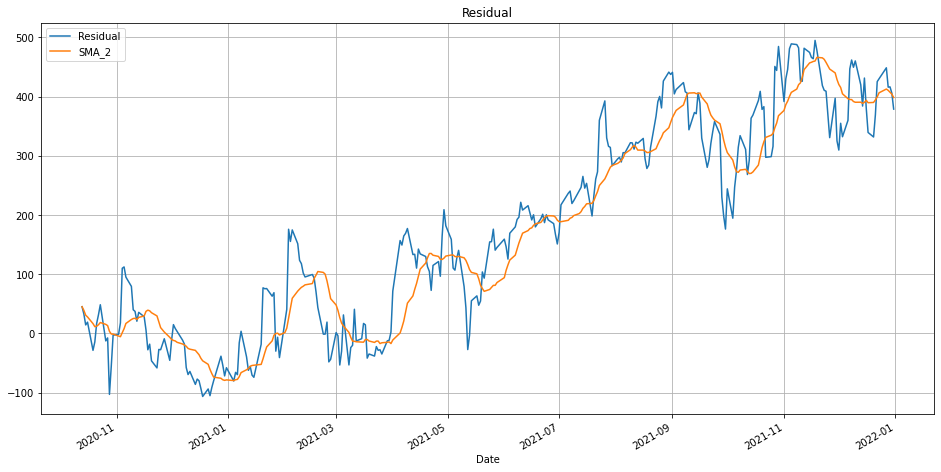

In [90]:
res[["Residual", "SMA_2"]].plot(title = 'Residual', figsize = (16,8), grid = True)

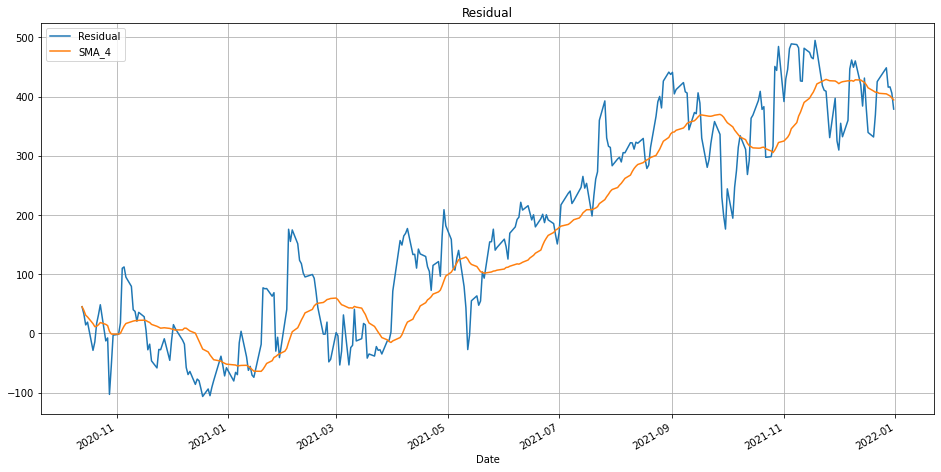

In [91]:
res[["Residual", "SMA_4"]].plot(title = 'Residual', figsize = (16,8), grid = True)

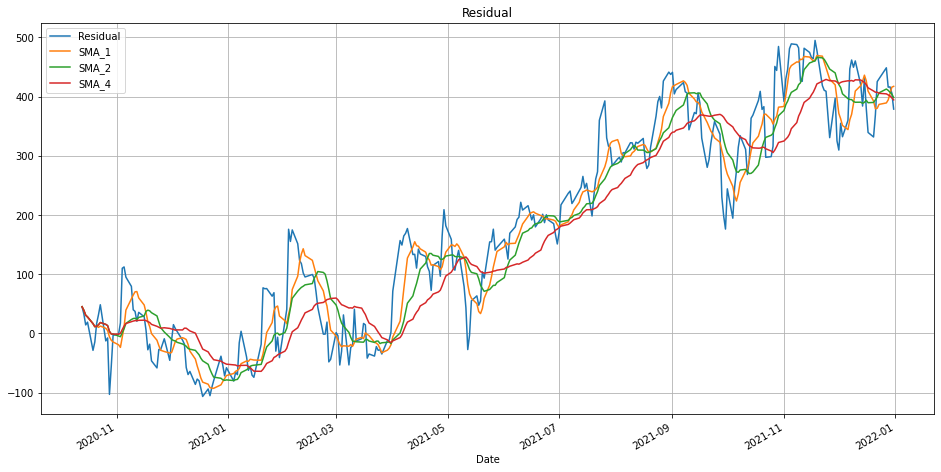

In [92]:
res.plot(title = 'Residual', figsize = (16,8), grid = True)